# 🌍 Generating 30,000 Random Land Points and Snapping to a Grid
This script below generates 30,000 random points located only on land across the world, filters out water/Antarctica, and then snaps them to a uniform grid of coordinates. Since I'm going to work with large geospatial datasets (6 million+ global points) and I want to downsample to a smaller, land-only subset.

✅ Output Files

30k_land_points.csv → raw random land-only points.

30k_land_points_snapped.csv → grid-snapped + deduplicated points.


🚀 Summary Workflow

Download shapefile → Natural Earth countries

Filter Antarctica

Random sample points inside polygons → up to 30K

Save CSV (raw land points)

Snap points to a 0.1° grid → remove duplicates

Save final dataset

In [18]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point
from shapely.prepared import prep
import math
import requests
import zipfile
import io
import os
import sys
from time import time

# Parameters
N_POINTS = 30000
OUTPUT_CSV = "../data/raw/30k_land_points.csv"
NE_ZIP_URL = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"

def load_naturalearth_countries(url=NE_ZIP_URL, fallback_dir="naturalearth_tmp"):
    try:
        
        print("Reading Natural Earth using URL...")
        gdf = gpd.read_file(url)
        print("Succsessfully read shapefile using URL.")
        return gdf
    except Exception as e:
        print("Failed to read URL (GDAL/remote). Downloading and unpacking locally.")
        os.makedirs(fallback_dir, exist_ok=True)
        r = requests.get(url, stream=True, timeout=30)
        r.raise_for_status()
        z = zipfile.ZipFile(io.BytesIO(r.content))
        z.extractall(fallback_dir)
        shp_files = [f for f in os.listdir(fallback_dir) if f.endswith(".shp")]
        if not shp_files:
            raise RuntimeError("No .shp file.")
        shp_path = os.path.join(fallback_dir, shp_files[0])
        gdf = gpd.read_file(shp_path)
        return gdf

def filter_out_antarctica(gdf):

    if 'CONTINENT' in gdf.columns:
        return gdf[gdf['CONTINENT'] != 'Antarctica']
    if 'continent' in gdf.columns:
        return gdf[gdf['continent'] != 'Antarctica']

    return gdf

def sample_points_on_land(n_points, land_geom_prep, batch=5000, seed=None):
    if seed is not None:
        np.random.seed(seed)
    pts = []
    t0 = time()
    tries = 0

    while len(pts) < n_points:
        remaining = n_points - len(pts)
        b = max(batch, int(remaining * 1.6))  
        
        u = np.random.uniform(-1.0, 1.0, size=b)
        lats = np.degrees(np.arcsin(u))
        lons = np.random.uniform(-180.0, 180.0, size=b)
        for lon, lat in zip(lons, lats):
            tries += 1
            p = Point(lon, lat)
            if land_geom_prep.contains(p):
                pts.append((lat, lon))
                if len(pts) >= n_points:
                    break

        if len(pts) % 5000 == 0 and len(pts) != 0:
            print(f"Points: {len(pts)} (tries {tries}, elapsed {time()-t0:.1f}s)")
    print(f"Ready: collected {len(pts)} points for {time()-t0:.1f}s (tries {tries}).")
    return pts

def main():
    gdf_countries = load_naturalearth_countries()
    gdf_countries = filter_out_antarctica(gdf_countries)

    land_union = gdf_countries.union_all()
    land_prep = prep(land_union)

    points = sample_points_on_land(N_POINTS, land_prep, batch=8000, seed=None)

    df = pd.DataFrame(points, columns=["latitude", "longitude"])
    df.insert(0, "id", range(1, len(df) + 1))
    df.to_csv(OUTPUT_CSV, index=False)
    print(f"Saved {len(df)} points in {OUTPUT_CSV}")

if __name__ == "__main__":
    main()


# parameters
INPUT_CSV = "../data/raw/30k_land_points.csv"   # id,latitude,longitude
OUTPUT_CSV = "../data/raw/30k_land_points_snapped.csv"
GRID_SIZE = 0.1               

def snap_to_grid(value, grid_size):
    return round(value / grid_size) * grid_size

# reading csv
df = pd.read_csv(INPUT_CSV)

# rounding coordinates
df["latitude"] = df["latitude"].apply(lambda x: snap_to_grid(x, GRID_SIZE))
df["longitude"] = df["longitude"].apply(lambda x: snap_to_grid(x, GRID_SIZE))

# removing duplicates
df = df.drop_duplicates(subset=["latitude", "longitude"]).reset_index(drop=True)

df["latitude"] = df["latitude"].round(1)
df["longitude"] = df["longitude"].round(1)

# saving
df.to_csv(OUTPUT_CSV, index=False)
print(f"Done! {len(df)} points saved in {OUTPUT_CSV}")

Reading Natural Earth using URL...
Succsessfully read shapefile using URL.
Points: 30000 (tries 113045, elapsed 1.0s)
Ready: collected 30000 points for 1.0s (tries 113045).
Saved 30000 points in ../data/raw/30k_land_points.csv
Done! 29707 points saved in ../data/raw/30k_land_points_snapped.csv


# 🔍 Primary Dataset Exploration
After generating and snapping the 30k land points dataset, the next step is to explore external climate datasets (AgERA5). This script demonstrates how to load and prepare point data alongside climate data stored in NetCDF (.nc) files.

The script below prints the metadata of the Solar Radiation dataset:

Variable names (e.g., ssr for surface solar radiation)

Dimensions (e.g., time, latitude, longitude)

Coordinate references

In [21]:
import pandas as pd
import xarray as xr
import numpy as np
from math import sin, cos, pi, acos, tan, radians

# === 1. Loading points ===
points = pd.read_csv("../data/raw/30k_land_points_snapped.csv")  

# === 2. Loading AgERA5 ===
solar_ds = xr.open_mfdataset(r"../data/raw/Solar_Radiation/Solar Radiation/*.nc", combine="by_coords")
cloud_ds = xr.open_mfdataset(r"../data/raw/Cloud_Cover/Cloud Cover/*.nc", combine="by_coords")

print(solar_ds)


<xarray.Dataset> Size: 9GB
Dimensions:               (time: 366, lat: 1801, lon: 3600)
Coordinates:
  * lat                   (lat) float64 14kB 90.0 89.9 89.8 ... -89.9 -90.0
  * lon                   (lon) float64 29kB -180.0 -179.9 ... 179.8 179.9
  * time                  (time) datetime64[ns] 3kB 2024-01-01 ... 2024-12-31
Data variables:
    Solar_Radiation_Flux  (time, lat, lon) float32 9GB dask.array<chunksize=(1, 901, 1800), meta=np.ndarray>
    crs                   (time) int64 3kB dask.array<chunksize=(1,), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.7
    title:        AgERA5 daily weather variables derived from the ECMWF ERA5 ...
    institution:  Wageningen Environmental Research
    history:      Generated by `pragera5 run_daily_processing 2024-01-01` ver...
    references:   https://doi.org/10.24381/cds.6c68c9bb
    source:       ECWMF ERA5 reanalysis, https://doi.org/10.24381/cds.143582cf


# 🔗 Connecting Land Points with AgERA5 Data
This step links the 30k land points with corresponding values from the AgERA5 climate datasets (Solar Radiation & Cloud Cover). The result is a point-level dataset that combines randomly sampled days with real climate variable values.

Each of the 30k land points is matched with:

A random day from AgERA5

Nearest-grid solar radiation

Nearest-grid cloud cover

Produces a point-level dataset, ready for modeling, visualization, or further statistical exploration.

In [25]:
import pandas as pd
import xarray as xr
import numpy as np

#points = pd.read_csv("../data/raw/30k_land_points_snapped.csv")  # id, lat, lon
#solar_ds = xr.open_mfdataset(r"../data/raw/Solar_Radiation/Solar Radiation/*.nc", combine="by_coords", chunks={"time": 50})

points = points.rename(columns={
    'latitude': 'lat',
    'longitude': 'lon'
})

np.random.seed(42)
random_days = np.random.choice(solar_ds.time.values, size=len(points))

# === Solar Radiation DataFrame ===
solar_sel = solar_ds.sel(
    time=xr.DataArray(random_days, dims="points"),
    lat=xr.DataArray(points.lat.values, dims="points"),
    lon=xr.DataArray(points.lon.values, dims="points"),
    method="nearest"
)

solar_df = solar_sel.to_dataframe().reset_index()

# === Cloud Cover DataFrame ===
cloud_sel = cloud_ds.sel(
    time=xr.DataArray(random_days, dims="points"),
    lat=xr.DataArray(points.lat.values, dims="points"),
    lon=xr.DataArray(points.lon.values, dims="points"),
    method="nearest"
)

cloud_df = cloud_sel.to_dataframe().reset_index()

df = pd.merge(solar_df, cloud_df, on=["lat", "lon", "time"])

print(df.head())

df.to_csv('../data/raw/points_with_agera.csv', index=False)

   points_x  Solar_Radiation_Flux  crs_x   lat   lon       time  points_y  \
0         0          2.141054e+07      1 -26.0  16.5 2024-04-12         0   
1         1          1.280719e+06      1  57.9  71.9 2024-12-14         1   
2         2          1.168188e+07      1  -8.3 -72.6 2024-09-27         2   
3         3          2.754259e+07      1  34.3  -1.5 2024-04-16         3   
4         4          1.796786e+07      1 -11.7  27.0 2024-03-12         4   

   Cloud_Cover_Mean_24h  crs_y  
0              0.155480      1  
1              0.901007      1  
2              0.917308      1  
3              0.021620      1  
4              0.896541      1  


# 🏔️ Adding Elevation Feature from DEM Dataset
After connecting the land points with AgERA5 climate data, this step adds elevation information from a Digital Elevation Model (DEM) dataset. 
Benefits of Adding Elevation:

Climate modeling: Elevation affects temperature, precipitation, and solar radiation.

Feature engineering: Can derive slope, aspect, or elevation bands.

Spatial analysis: Helps explain climate patterns across different terrains.



In [36]:
import xarray as xr
import pandas as pd

#df = pd.read_csv('points_with_agera.csv')

dem = xr.open_dataset("../data/raw/GMTED2010_15n030_0125deg.nc")

elev_data = dem['elevation']

df['elevation'] = elev_data.sel(
    latitude=xr.DataArray(df['lat'].values, dims='points'),
    longitude=xr.DataArray(df['lon'].values, dims='points'),
    method='nearest'
).values

print(df)
df.to_csv('../data/raw/points_with_agera.csv', index=False)

       points_x  Solar_Radiation_Flux  crs_x   lat    lon       time  \
0             0          2.141054e+07      1 -26.0   16.5 2024-04-12   
1             1          1.280719e+06      1  57.9   71.9 2024-12-14   
2             2          1.168188e+07      1  -8.3  -72.6 2024-09-27   
3             3          2.754259e+07      1  34.3   -1.5 2024-04-16   
4             4          1.796786e+07      1 -11.7   27.0 2024-03-12   
...         ...                   ...    ...   ...    ...        ...   
29702     29702          2.418710e+07      1  18.0  -88.8 2024-05-22   
29703     29703          1.419906e+07      1  29.8   -1.2 2024-12-03   
29704     29704          1.047945e+07      1  30.1  -84.8 2024-12-23   
29705     29705          2.006867e+07      1  -2.9  112.4 2024-01-24   
29706     29706          1.750960e+07      1 -11.4  -37.5 2024-05-20   

       points_y  Cloud_Cover_Mean_24h  crs_y  elevation  
0             0              0.155480      1       1742  
1             1    

### 📊 🔍 Exploring missing values

The script below shows counts and percentages per column.

Identifies problematic rows, displaying sample rows with missing data.


In [38]:
import pandas as pd
import numpy as np

# Load the dataset (if not already in memory)
# df = pd.read_csv('../data/raw/points_with_agera.csv')

# === 1. EXPLORE MISSING VALUES ===

print("=== MISSING VALUES EXPLORATION ===")
print(f"Dataset shape: {df.shape}")
print()

# Count missing values per column
missing_counts = df.isnull().sum()
missing_percentages = (df.isnull().sum() / len(df)) * 100

missing_summary = pd.DataFrame({
    'Missing_Count': missing_counts,
    'Missing_Percentage': missing_percentages
})

print("Missing values by column:")
print(missing_summary[missing_summary['Missing_Count'] > 0])
print()

# Total rows with any missing values
rows_with_missing = df.isnull().any(axis=1).sum()
print(f"Rows with any missing values: {rows_with_missing} ({rows_with_missing/len(df)*100:.2f}%)")
print()

# Show some examples of rows with missing values
if rows_with_missing > 0:
    print("Sample rows with missing values:")
    print(df[df.isnull().any(axis=1)].head())
    print()


=== MISSING VALUES EXPLORATION ===
Dataset shape: (29707, 10)

Missing values by column:
                      Missing_Count  Missing_Percentage
Solar_Radiation_Flux             40            0.134648
Cloud_Cover_Mean_24h             40            0.134648

Rows with any missing values: 40 (0.13%)

Sample rows with missing values:
      points_x  Solar_Radiation_Flux  crs_x   lat   lon       time  points_y  \
113        113                   NaN      1  44.3 -86.8 2024-09-24       113   
239        239                   NaN      1  45.3 -82.8 2024-09-15       239   
1495      1495                   NaN      1  43.0 -86.9 2024-11-06      1495   
3115      3115                   NaN      1  45.7 -81.2 2024-07-08      3115   
3124      3124                   NaN      1  45.7 -86.2 2024-06-02      3124   

      Cloud_Cover_Mean_24h  crs_y  elevation  
113                    NaN      1        175  
239                    NaN      1        175  
1495                   NaN      1        175 

**Since missing values are only 0.13%, we can simply remove them**

The script below 

🧹 Removes missing values - drops rows with any NaN values

📊 Drops unnesessary columns

🔆 Converting Solar Radiation to MJ/m²

The AgERA5 dataset provides solar radiation flux in Joules per square meter (J/m²). 
For many agronomic and climatological applications, it's more useful to have this expressed in megajoules per square meter (MJ/m²).

💾 Saves cleaned dataset - exports to processed data folder

✅ Verifies results - confirm no missing values remain

*We don't impute missing values but simply remove them, there is no risk of data leakage. Therefore, the dataset can be split into training and test sets directly before modeling.*

In [54]:
# === 2. REMOVE MISSING VALUES ===

print("=== REMOVING MISSING VALUES ===")
original_length = len(df)

# Remove rows with any missing values
df_clean = df.dropna().copy()

removed_count = original_length - len(df_clean)
print(f"Removed {removed_count} rows with missing values")
print(f"Dataset shape after cleaning: {df_clean.shape}")
print(f"Retention rate: {len(df_clean)/original_length*100:.2f}%")

# === 3. Round coordinates and Converting Solar Radiation to MJ/m² ===
df_clean["lat"] = df_clean["lat"].round(1)
df_clean["lon"] = df_clean["lon"].round(1)
df_clean["Solar_Radiation_Flux"] = df_clean["Solar_Radiation_Flux"]/ 1000000

# === 4. SAVE CLEANED DATASET and drop unnesessary columns ===
df_clean[["time", "lat", "lon", "Solar_Radiation_Flux", "Cloud_Cover_Mean_24h", "elevation"]].to_csv('../data/processed/points_with_agera_clean.csv', index=False)
print(f"\nCleaned dataset saved to: '../data/processed/points_with_agera_clean.csv'")

# === 5. FINAL VERIFICATION ===
print("\n=== FINAL VERIFICATION ===")
print(f"Any missing values remaining: {df_clean.isnull().sum().sum()}")
print("Dataset info:")
print(df_clean.info())

=== REMOVING MISSING VALUES ===
Removed 40 rows with missing values
Dataset shape after cleaning: (29667, 10)
Retention rate: 99.87%

Cleaned dataset saved to: '../data/processed/points_with_agera_clean.csv'

=== FINAL VERIFICATION ===
Any missing values remaining: 0
Dataset info:
<class 'pandas.core.frame.DataFrame'>
Index: 29667 entries, 0 to 29706
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   points_x              29667 non-null  int64         
 1   Solar_Radiation_Flux  29667 non-null  float64       
 2   crs_x                 29667 non-null  int64         
 3   lat                   29667 non-null  float64       
 4   lon                   29667 non-null  float64       
 5   time                  29667 non-null  datetime64[ns]
 6   points_y              29667 non-null  int64         
 7   Cloud_Cover_Mean_24h  29667 non-null  float32       
 8   crs_y                 29667 n

# 🌞 Adding Sunlight & Daylength Features
This script below enriches the dataset with astronomical features:

**Sunlight hours (sunlight_hours) → based on twilight-adjusted solar geometry**

Uses astronomy equations to calculate daylight duration at a given latitude, longitude, and date.

Handles edge cases: 

Polar day (24 h sunlight)

Polar night (0 h sunlight)

**Astronomical day length (daylength) → from FAO‑56 equations**

Daylength (daylength) = theoretical max daylight hours at top of atmosphere

**Extraterrestrial solar radiation (H0) (H0_MJ) → solar potential above the atmosphere, from FAO‑56 reference equations.**

Extraterrestrial radiation (H0_MJ) = incoming solar energy in MJ/m²/day before atmospheric effects

**Cyclic encoding of seasonality (doy_sin, doy_cos) → captures annual periodicity**

Projects day-of-year (1–365) onto a sine/cosine circle.

Prevents issues in ML models where day 1 (Jan 1) and day 365 (Dec 31) would otherwise appear far apart.

In [37]:
import numpy as np
import pandas as pd

df = pd.read_csv('../data/processed/points_with_agera_clean.csv')

# Convert the time column to datetime
df['time'] = pd.to_datetime(df['time'])

def calc_daylength(lat, lon, date, twilight=-0.833):
    if pd.isnull(lat) or pd.isnull(lon) or pd.isnull(date):
        return None

    if isinstance(date, pd.Timestamp):
        date = date.date()

    doy = date.timetuple().tm_yday

    # solar anomaly
    gamma = 2 * np.pi / 365 * (doy - 1)
    delta = (0.006918
             - 0.399912 * np.cos(gamma) + 0.070257 * np.sin(gamma)
             - 0.006758 * np.cos(2*gamma) + 0.000907 * np.sin(2*gamma)
             - 0.002697 * np.cos(3*gamma) + 0.001480 * np.sin(3*gamma))

    lat_rad = np.deg2rad(lat)
    a0 = np.deg2rad(twilight)

    cosH0 = (np.sin(a0) - np.sin(lat_rad) * np.sin(delta)) / (np.cos(lat_rad) * np.cos(delta))

    if cosH0 <= -1:   
        return 24.0
    elif cosH0 >= 1:  
        return 0.0
    else:
        H0 = np.arccos(cosH0)
        return (2 * H0 * 180 / np.pi) / 15.0   # часы

def add_sunlight_duration(df, date_col='time', lat_col='lat', lon_col='lon', twilight=-0.833):
    df = df.copy()
    df['sunlight_hours'] = df.apply(
        lambda row: calc_daylength(row[lat_col], row[lon_col], row[date_col], twilight=twilight),
        axis=1
    )
    return df

df = add_sunlight_duration(df)

# Add sine/cosine of the day of the year

doy = df["time"].dt.dayofyear + np.random.uniform(0, 1, size=len(df))
df["doy_sin"] = np.sin(2*np.pi*doy/365.0)
df["doy_cos"] = np.cos(2*np.pi*doy/365.0)

def calculate_daylength_and_H0(df, lat_col="lat", lon_col="lon", date_col="date"):
    """
    Compute astronomical daylength (N) and extraterrestrial radiation (H0) for each row.
    Based on FAO-56 equations.
    Fixed to handle polar day/night conditions.
    """
    results_daylength = []
    results_H0 = []

    for _, row in df.iterrows():
        lat_rad = np.radians(row[lat_col])
        date = pd.to_datetime(row[date_col])
        J = date.dayofyear  # Day of year

        # Solar declination δ
        delta = 0.409 * np.sin((2 * np.pi / 365) * J - 1.39)

        # Inverse relative distance Earth–Sun dr
        dr = 1 + 0.033 * np.cos(2 * np.pi / 365 * J)

        # Check for polar conditions
        # Check for polar conditions
        tan_product = np.tan(lat_rad) * np.tan(delta)

        if tan_product >= 1:
            # Polar day - sun never sets
            ws = np.pi
            N = 24.0
        elif tan_product <= -1:
            # Polar night - sun never rises
            ws = 0.0
            N = 0.0
        else:
            # Normal conditions
            ws = np.arccos(-tan_product)
            N = (24 / np.pi) * ws

        # Solar constant Gsc (MJ m^-2 min^-1)
        Gsc = 0.0820  

        # Extraterrestrial radiation H0 (MJ/m²/day)
        H0 = (24 * 60 / np.pi) * Gsc * dr * (
            ws * np.sin(lat_rad) * np.sin(delta) +
            np.cos(lat_rad) * np.cos(delta) * np.sin(ws)
        ) 

        results_daylength.append(N)
        results_H0.append(H0)

    df["daylength"] = results_daylength
    df["H0_MJ"] = results_H0
    return df


df = calculate_daylength_and_H0(df, lat_col="lat", lon_col="lon", date_col="time")

df.to_csv('../data/processed/clean_with_features.csv')

print(df.head())

        time   lat   lon  Solar_Radiation_Flux  Cloud_Cover_Mean_24h  \
0 2024-04-12 -26.0  16.5             21.410544              0.155480   
1 2024-12-14  57.9  71.9              1.280719              0.901007   
2 2024-09-27  -8.3 -72.6             11.681878              0.917308   
3 2024-04-16  34.3  -1.5             27.542588              0.021620   
4 2024-03-12 -11.7  27.0             17.967862              0.896541   

   elevation  sunlight_hours   doy_sin   doy_cos  daylength      H0_MJ  
0       1742       11.550764  0.976392 -0.216008  11.425388  29.345531  
1        109        6.552957 -0.267322  0.963607   6.208947   3.167869  
2        218       12.145343 -0.999223 -0.039401  12.060713  37.543336  
3       1145       13.077199  0.960787 -0.277289  12.943193  36.374315  
4       1359       12.202776  0.946791  0.321849  12.097189  37.875241  


# ✅ Final Dataset Columns

| Column                 | Description                          | Units        | Source                |
|-------------------------|--------------------------------------|--------------|-----------------------|
| lat, lon               | Coordinates                          | °            | 30k land points       |
| time                   | Random day                           | YYYY-MM-DD   | AgERA5                |
| Solar_Radiation_Flux   | Incident solar radiation             | MJ/m²        | AgERA5 (converted)    |
| Cloud_Cover            | Cloud fraction                       | %            | AgERA5                |
| elevation              | Terrain height                       | m            | GMTED2010 DEM         |
| sunlight_hours         | Actual sunlight hours (twilight-based)| h            | Astronomical calc     |
| daylength              | Astronomical day length (FAO-56)     | h            | FAO-56 eq.            |
| H0_MJ                  | Extraterrestrial radiation           | MJ/m²/day    | FAO-56 eq.            |
| doy_sin, doy_cos       | Seasonal cycle features              | unitless     | Derived               |


# 📊 Data Exploration
With the script below, we're going to explore and understand the dataset before performing any modeling. This exploration will cover:

**Distributions of Key Variables**

To understand the range and spread of solar radiation, cloud cover, sunlight hours, elevation, and astronomical factors.

**Geographic Distribution**

Mapping solar radiation and elevation across latitude and longitude.

**Correlations**

Identifying which features are correlated and could be useful predictors.

**Time Series Trends**

Looking for seasonality across months in solar radiation, cloud cover, and daylight duration.

**Variable Relationships**

How solar radiation responds to latitude, cloudiness, elevation, and daylight.

**Seasonal Patterns**

Using day-of-year trigonometric encodings (doy_sin, doy_cos) to visualize annual cycles.

**Categorical Analysis**

Comparing distributions across latitude zones (south, equatorial, north) and elevation bands.

We’ll save each plot in ../outputs/figures/ to use in later reporting.

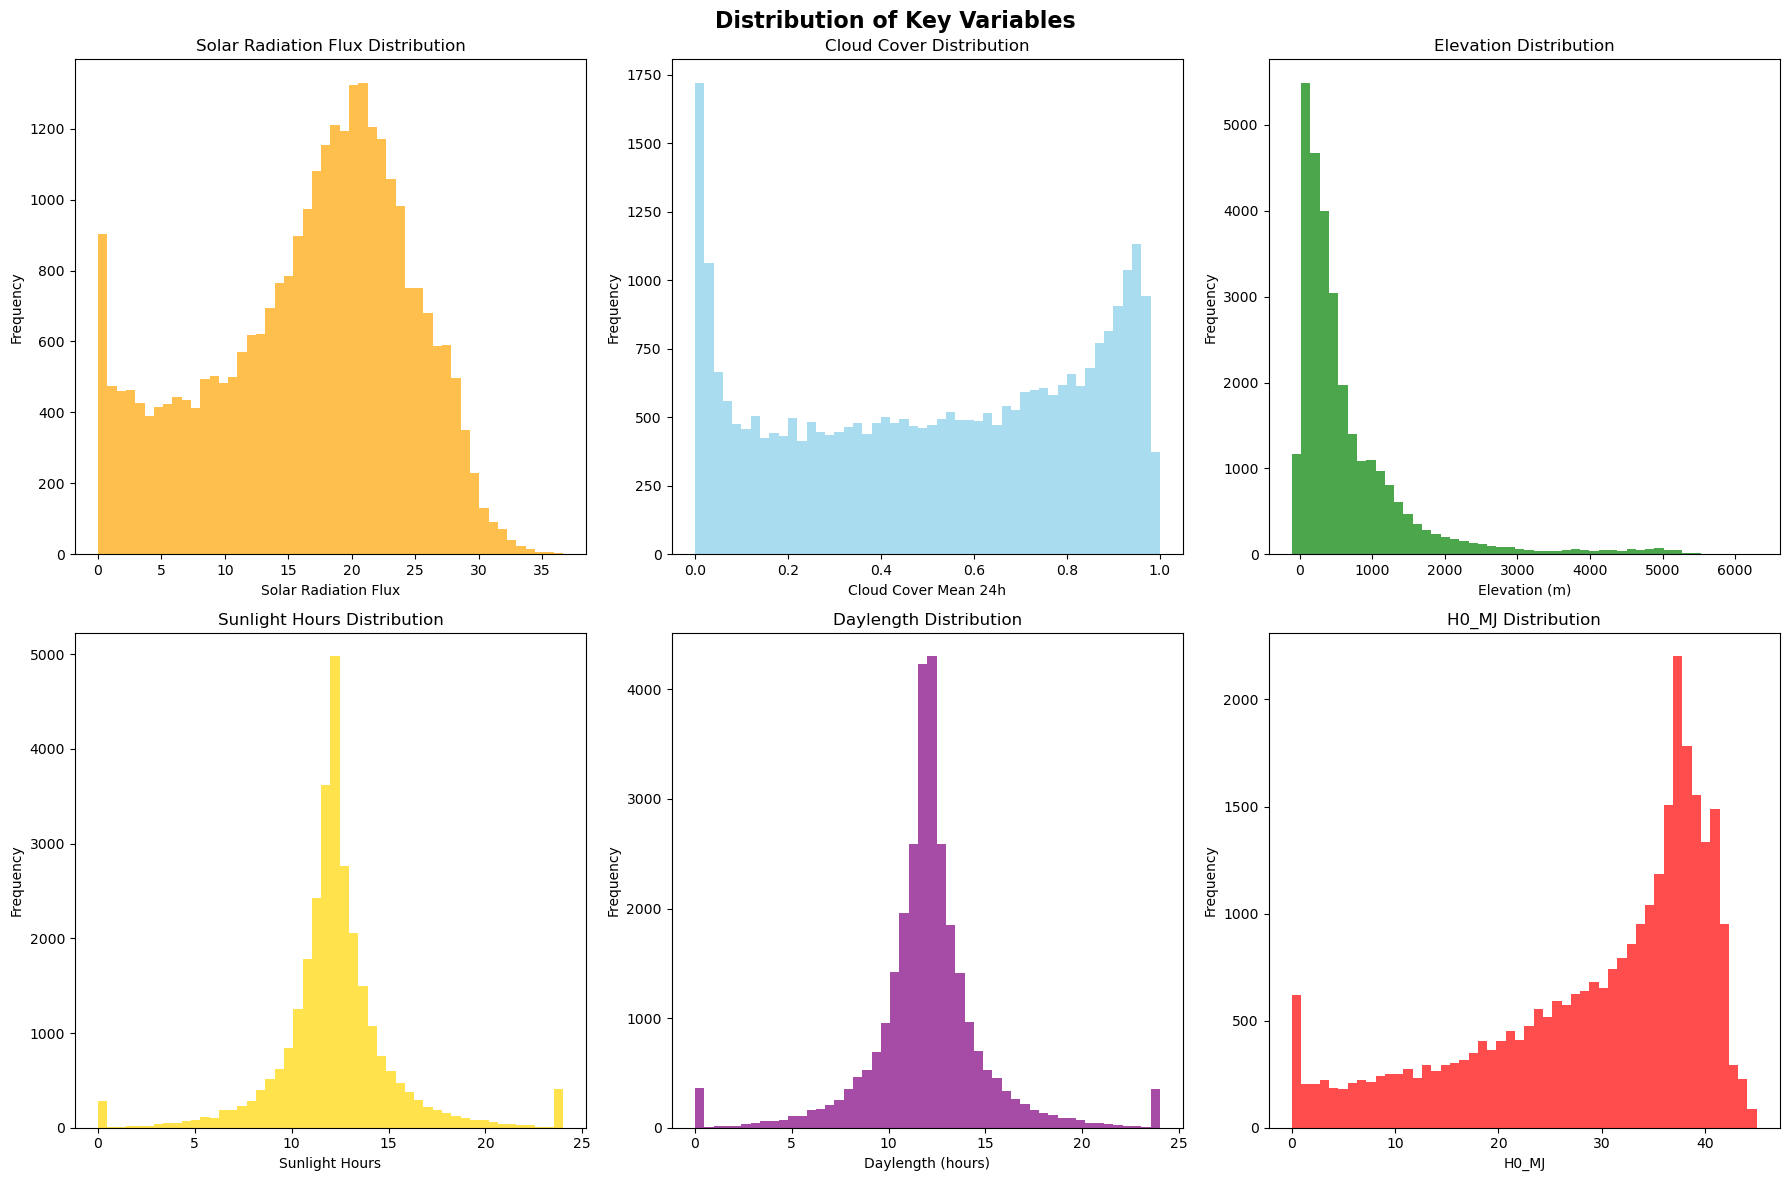

Saved: variable_distributions.png


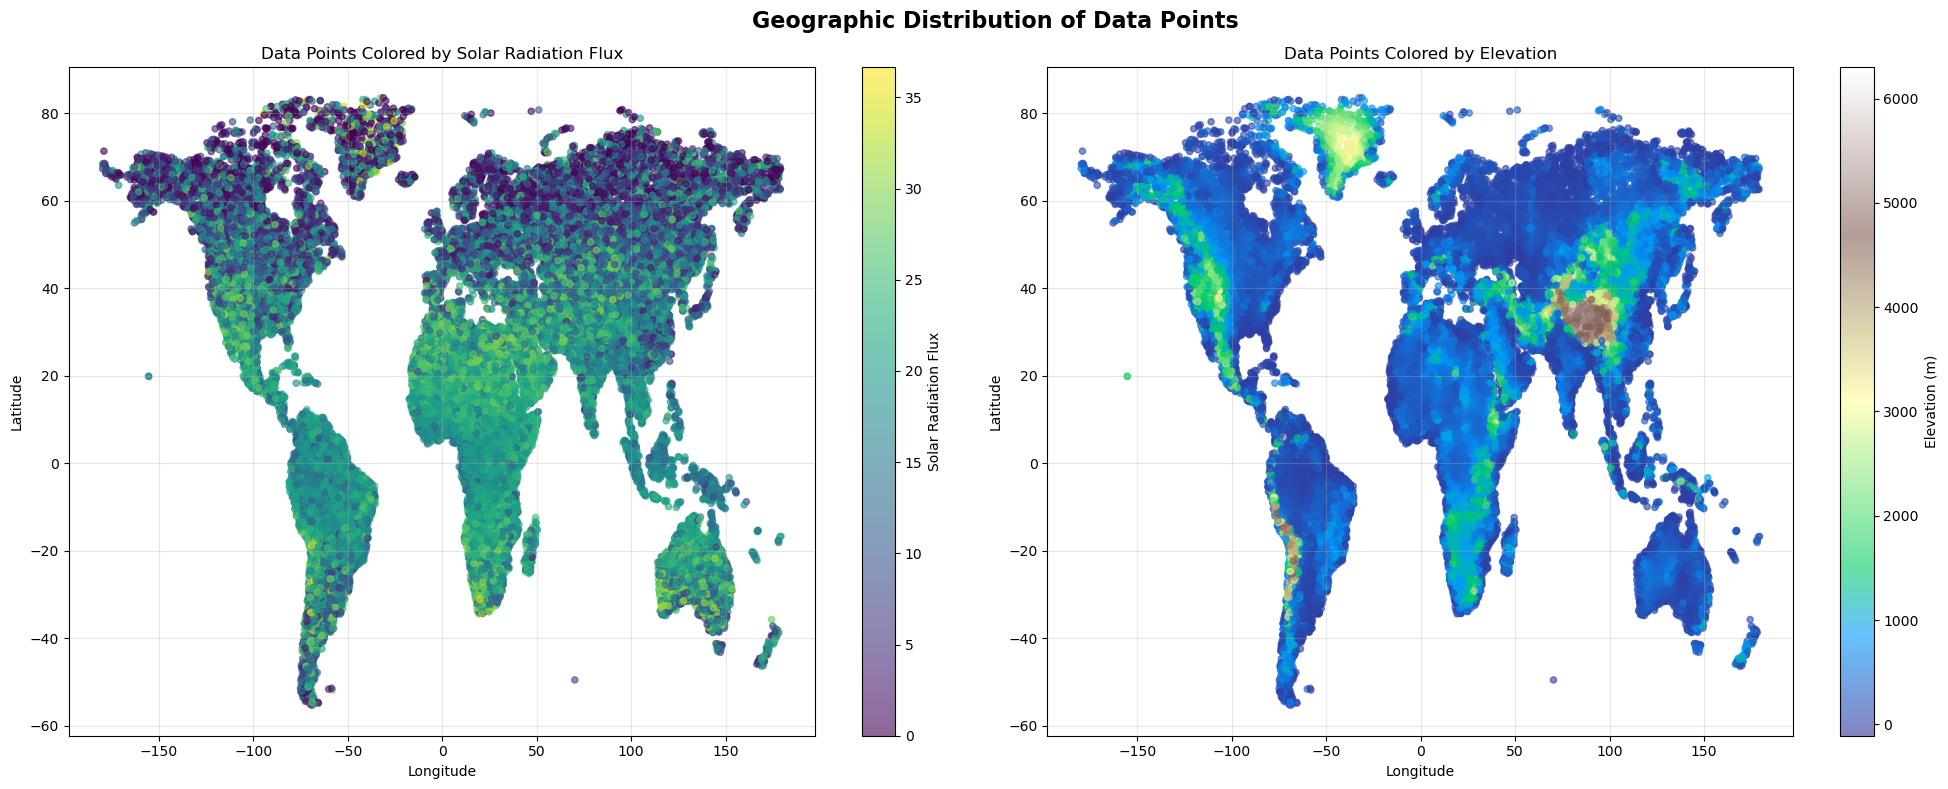

Saved: geographic_distribution.png


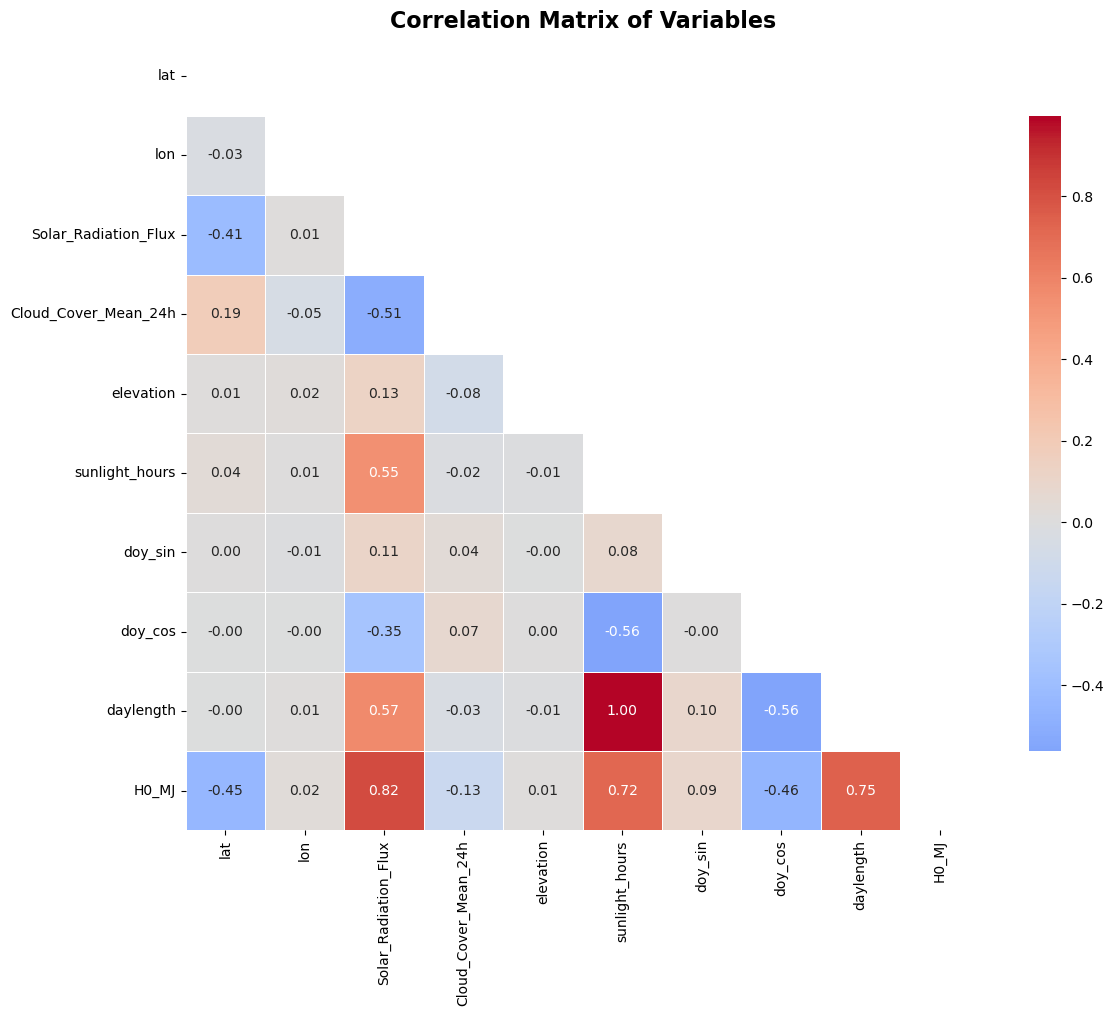

Saved: correlation_matrix.png


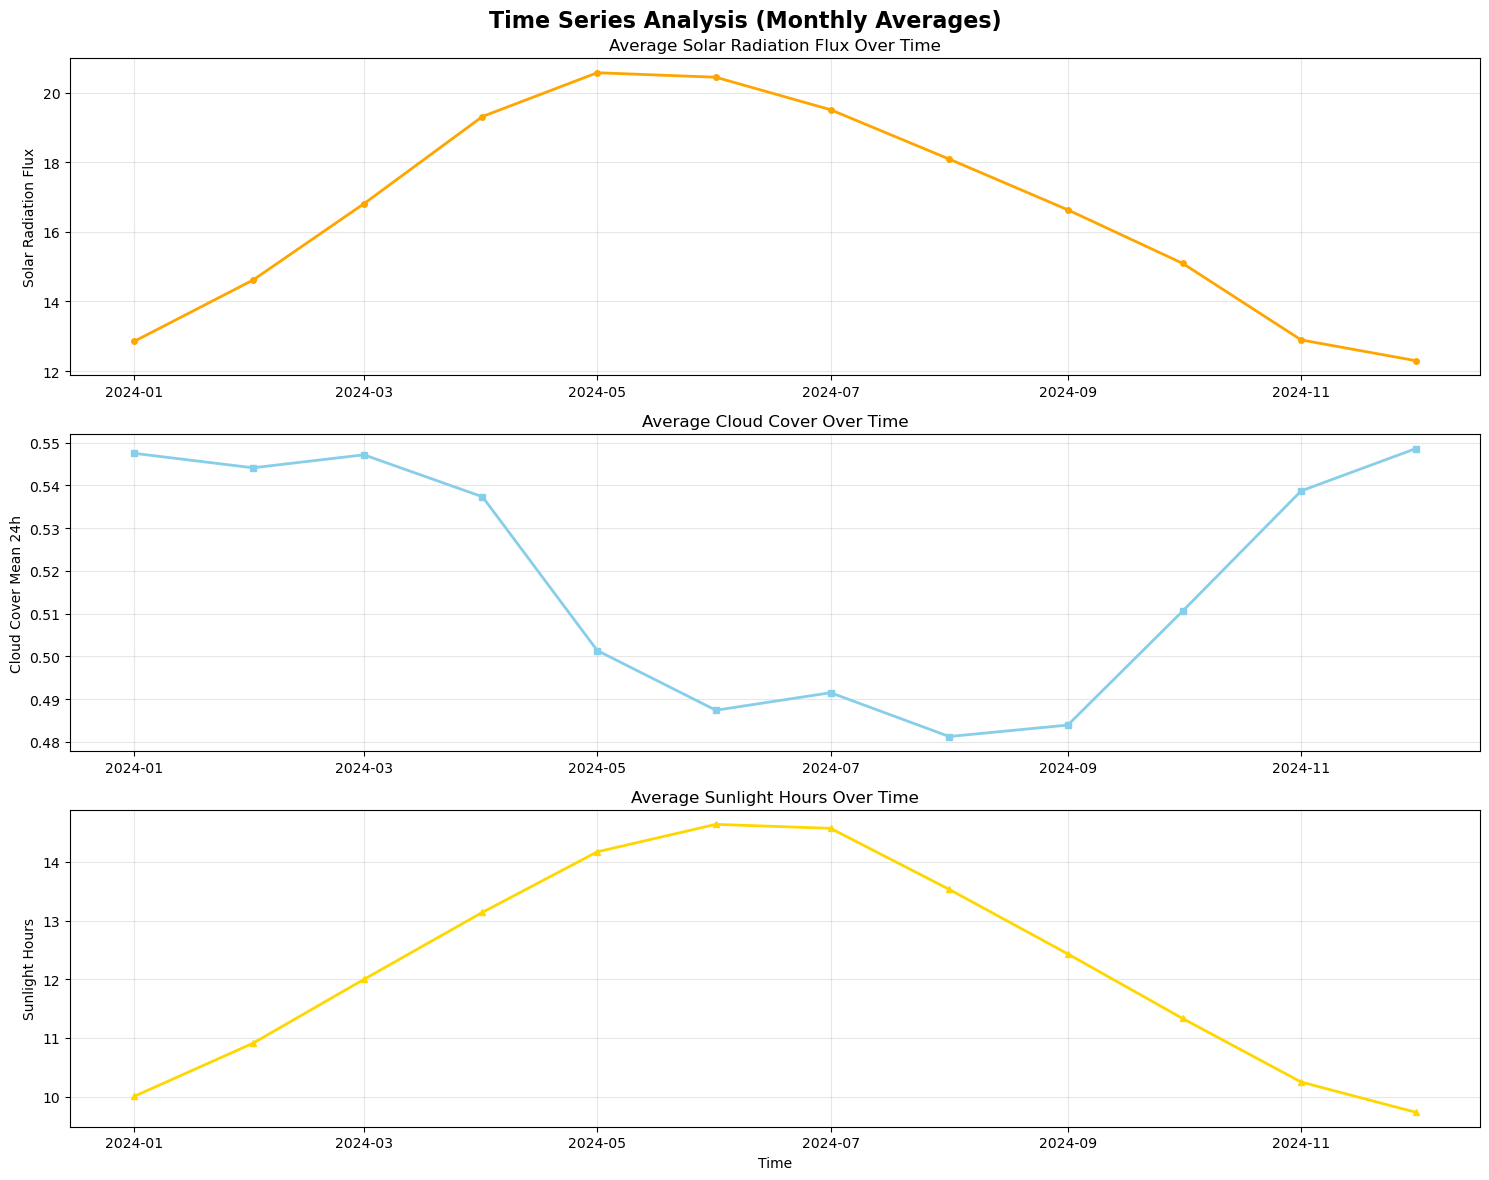

Saved: time_series_analysis.png


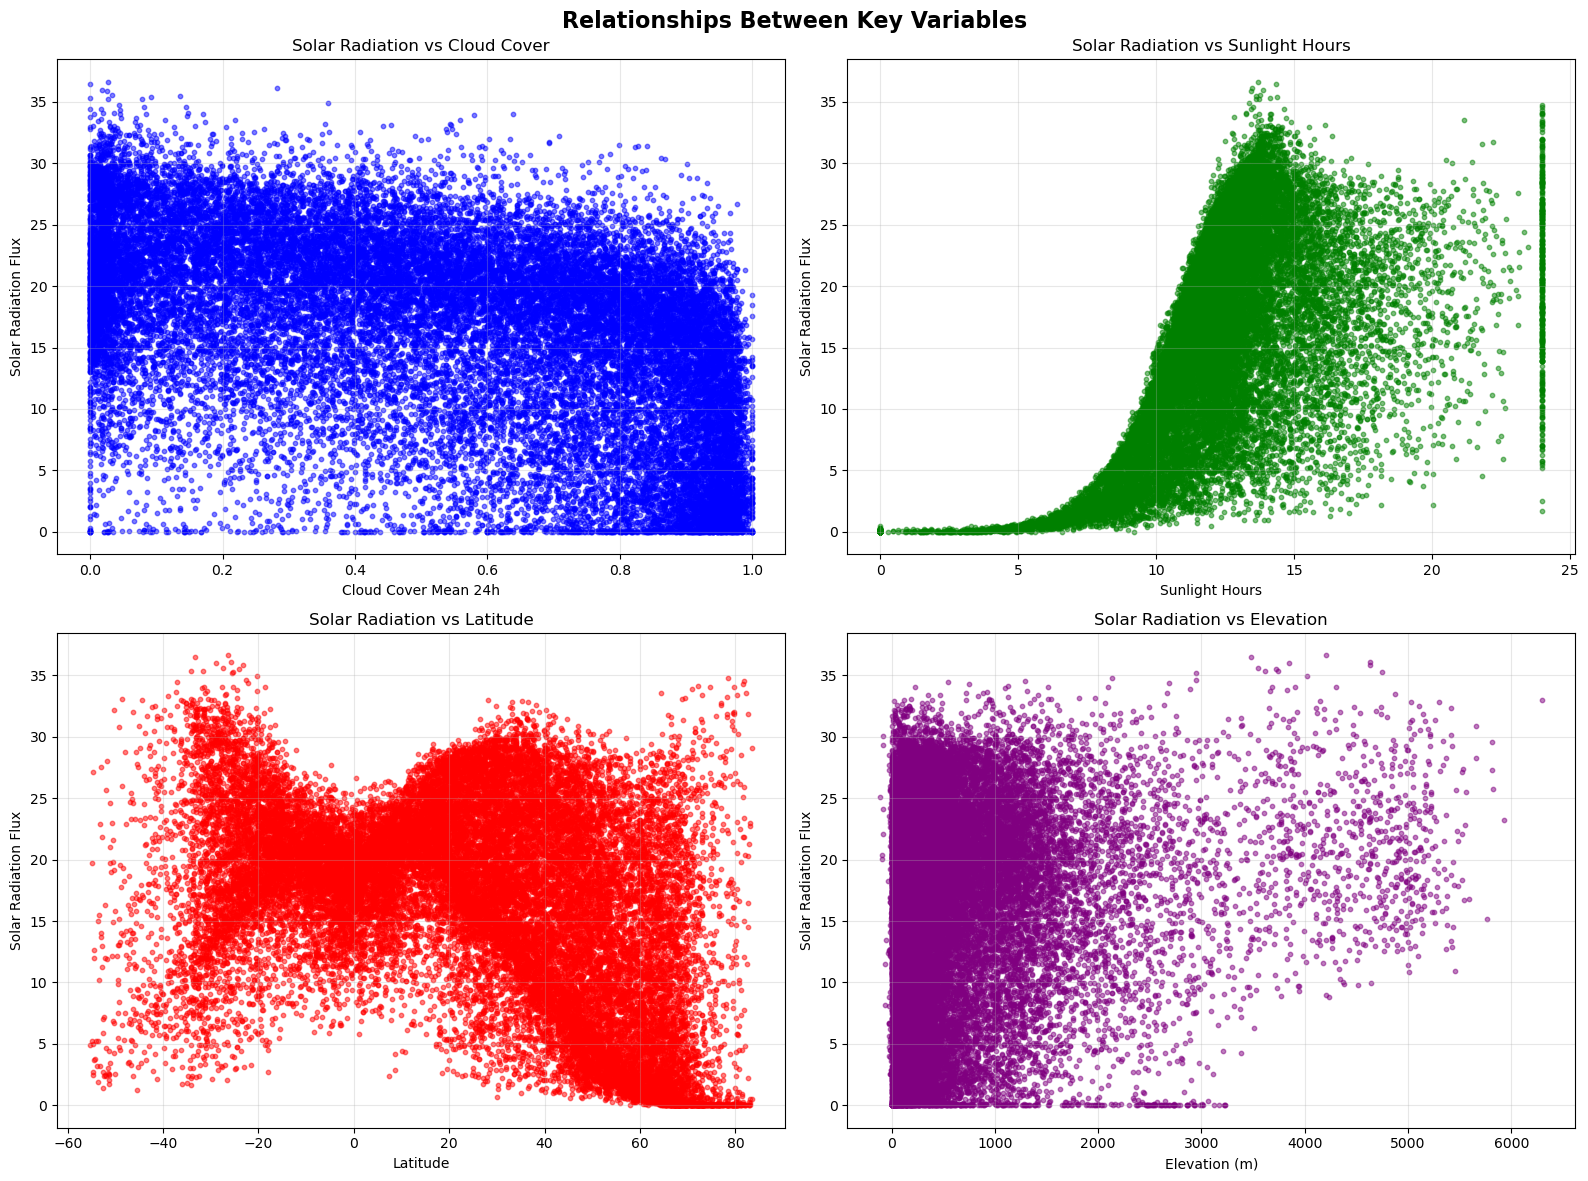

Saved: variable_relationships.png


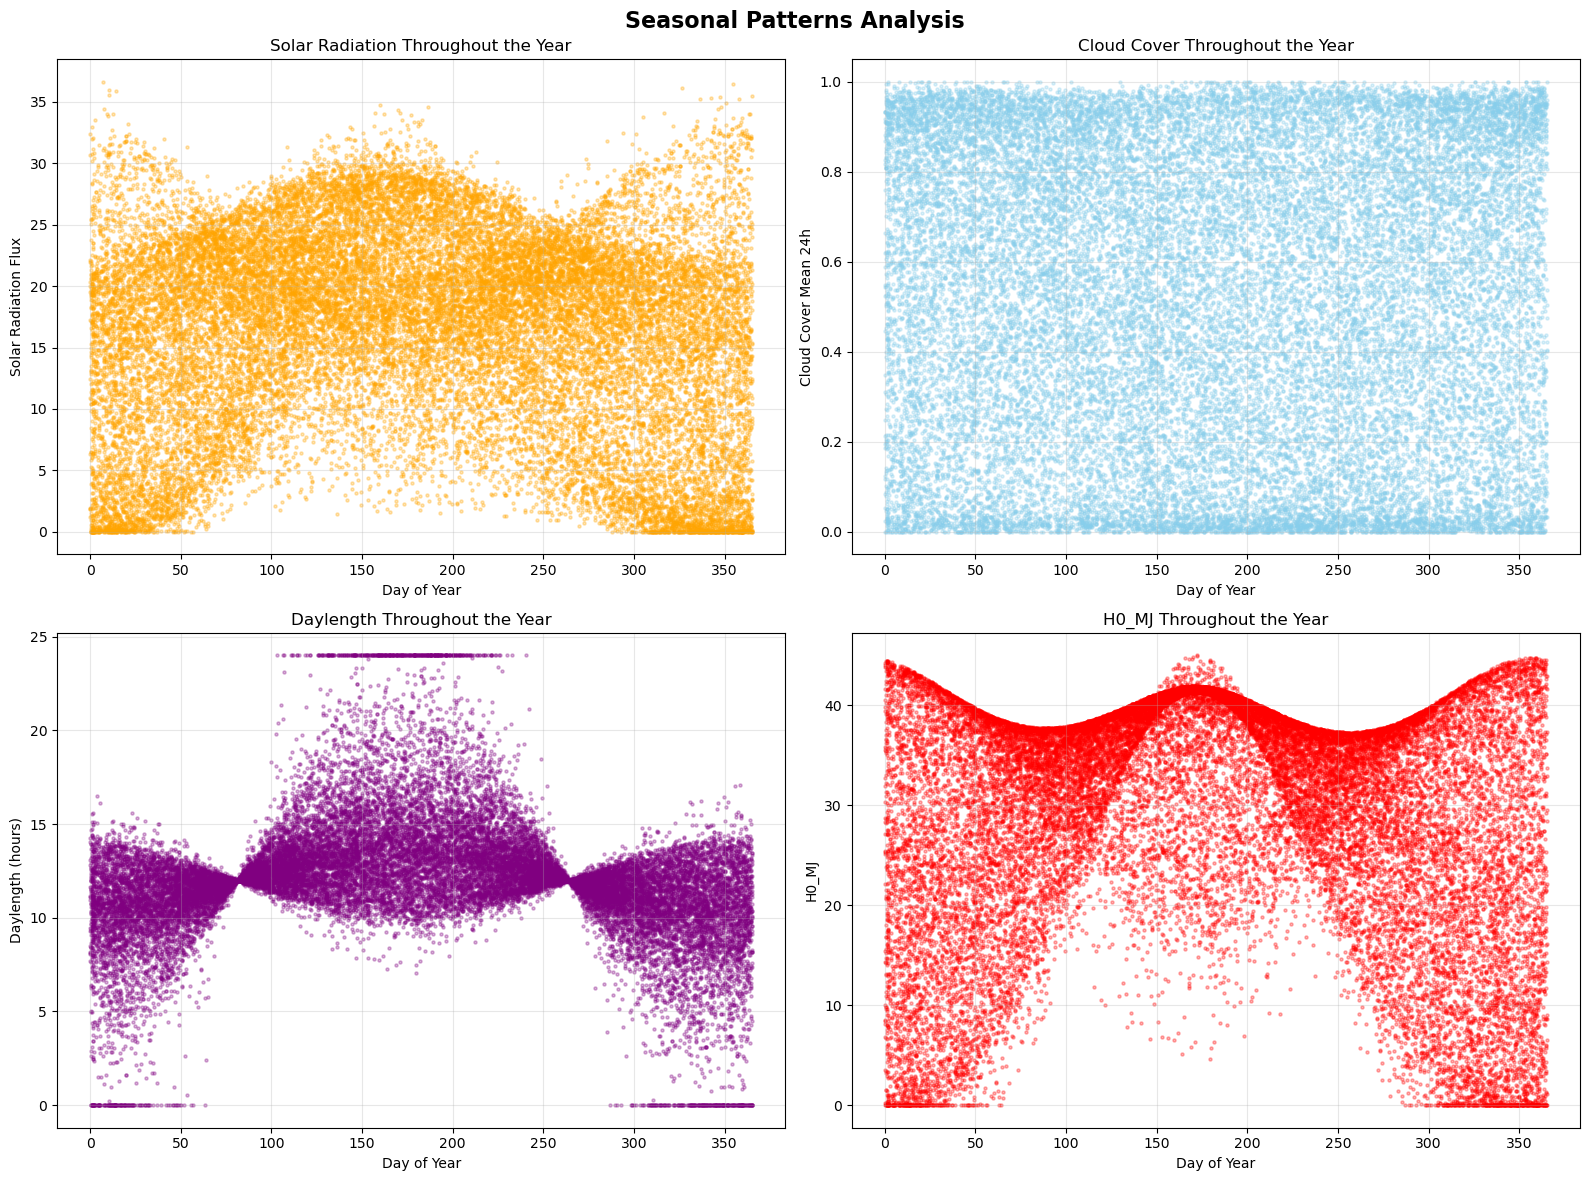

Saved: seasonal_patterns.png


In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os

# Load the dataset
df = pd.read_csv('../data/processed/clean_with_features.csv')

# Create output directory
os.makedirs('../outputs/figures/', exist_ok=True)

# Convert time to datetime
df['time'] = pd.to_datetime(df['time'])

# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")

# 1. Distribution of key variables
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Distribution of Key Variables', fontsize=16, fontweight='bold')

# Solar Radiation Flux
axes[0,0].hist(df['Solar_Radiation_Flux'], bins=50, alpha=0.7, color='orange')
axes[0,0].set_title('Solar Radiation Flux Distribution')
axes[0,0].set_xlabel('Solar Radiation Flux')
axes[0,0].set_ylabel('Frequency')

# Cloud Cover
axes[0,1].hist(df['Cloud_Cover_Mean_24h'], bins=50, alpha=0.7, color='skyblue')
axes[0,1].set_title('Cloud Cover Distribution')
axes[0,1].set_xlabel('Cloud Cover Mean 24h')
axes[0,1].set_ylabel('Frequency')

# Elevation
axes[0,2].hist(df['elevation'], bins=50, alpha=0.7, color='green')
axes[0,2].set_title('Elevation Distribution')
axes[0,2].set_xlabel('Elevation (m)')
axes[0,2].set_ylabel('Frequency')

# Sunlight Hours
axes[1,0].hist(df['sunlight_hours'], bins=50, alpha=0.7, color='gold')
axes[1,0].set_title('Sunlight Hours Distribution')
axes[1,0].set_xlabel('Sunlight Hours')
axes[1,0].set_ylabel('Frequency')

# Daylength
axes[1,1].hist(df['daylength'], bins=50, alpha=0.7, color='purple')
axes[1,1].set_title('Daylength Distribution')
axes[1,1].set_xlabel('Daylength (hours)')
axes[1,1].set_ylabel('Frequency')

# H0_MJ
axes[1,2].hist(df['H0_MJ'], bins=50, alpha=0.7, color='red')
axes[1,2].set_title('H0_MJ Distribution')
axes[1,2].set_xlabel('H0_MJ')
axes[1,2].set_ylabel('Frequency')

plt.tight_layout()
plt.savefig('../outputs/figures/variable_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: variable_distributions.png")

# 2. Geographic distribution
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Geographic Distribution of Data Points', fontsize=16, fontweight='bold')

# Scatter plot of locations
scatter = axes[0].scatter(df['lon'], df['lat'], c=df['Solar_Radiation_Flux'], 
                         cmap='viridis', alpha=0.6, s=20)
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
axes[0].set_title('Data Points Colored by Solar Radiation Flux')
axes[0].grid(True, alpha=0.3)
cbar1 = plt.colorbar(scatter, ax=axes[0])
cbar1.set_label('Solar Radiation Flux')

# Elevation map
scatter2 = axes[1].scatter(df['lon'], df['lat'], c=df['elevation'], 
                          cmap='terrain', alpha=0.6, s=20)
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
axes[1].set_title('Data Points Colored by Elevation')
axes[1].grid(True, alpha=0.3)
cbar2 = plt.colorbar(scatter2, ax=axes[1])
cbar2.set_label('Elevation (m)')

plt.tight_layout()
plt.savefig('../outputs/figures/geographic_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: geographic_distribution.png")

# 3. Correlation matrix
plt.figure(figsize=(12, 10))
# Select numeric columns for correlation
numeric_cols = ['lat', 'lon', 'Solar_Radiation_Flux', 'Cloud_Cover_Mean_24h', 
                'elevation', 'sunlight_hours', 'doy_sin', 'doy_cos', 'daylength', 'H0_MJ']
correlation_matrix = df[numeric_cols].corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8}, fmt='.2f')
plt.title('Correlation Matrix of Variables', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('../outputs/figures/correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: correlation_matrix.png")

# 4. Time series analysis
df_monthly = df.groupby(df['time'].dt.to_period('M')).agg({
    'Solar_Radiation_Flux': 'mean',
    'Cloud_Cover_Mean_24h': 'mean',
    'sunlight_hours': 'mean'
}).reset_index()
df_monthly['time'] = df_monthly['time'].dt.to_timestamp()

fig, axes = plt.subplots(3, 1, figsize=(15, 12))
fig.suptitle('Time Series Analysis (Monthly Averages)', fontsize=16, fontweight='bold')

# Solar Radiation over time
axes[0].plot(df_monthly['time'], df_monthly['Solar_Radiation_Flux'], 
             marker='o', linewidth=2, markersize=4, color='orange')
axes[0].set_title('Average Solar Radiation Flux Over Time')
axes[0].set_ylabel('Solar Radiation Flux')
axes[0].grid(True, alpha=0.3)

# Cloud Cover over time
axes[1].plot(df_monthly['time'], df_monthly['Cloud_Cover_Mean_24h'], 
             marker='s', linewidth=2, markersize=4, color='skyblue')
axes[1].set_title('Average Cloud Cover Over Time')
axes[1].set_ylabel('Cloud Cover Mean 24h')
axes[1].grid(True, alpha=0.3)

# Sunlight Hours over time
axes[2].plot(df_monthly['time'], df_monthly['sunlight_hours'], 
             marker='^', linewidth=2, markersize=4, color='gold')
axes[2].set_title('Average Sunlight Hours Over Time')
axes[2].set_ylabel('Sunlight Hours')
axes[2].set_xlabel('Time')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/figures/time_series_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: time_series_analysis.png")


# 5. Relationship between key variables
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Relationships Between Key Variables', fontsize=16, fontweight='bold')

# Solar Radiation vs Cloud Cover
axes[0,0].scatter(df['Cloud_Cover_Mean_24h'], df['Solar_Radiation_Flux'], 
                  alpha=0.5, s=10, color='blue')
axes[0,0].set_xlabel('Cloud Cover Mean 24h')
axes[0,0].set_ylabel('Solar Radiation Flux')
axes[0,0].set_title('Solar Radiation vs Cloud Cover')
axes[0,0].grid(True, alpha=0.3)

# Solar Radiation vs Sunlight Hours
axes[0,1].scatter(df['sunlight_hours'], df['Solar_Radiation_Flux'], 
                  alpha=0.5, s=10, color='green')
axes[0,1].set_xlabel('Sunlight Hours')
axes[0,1].set_ylabel('Solar Radiation Flux')
axes[0,1].set_title('Solar Radiation vs Sunlight Hours')
axes[0,1].grid(True, alpha=0.3)

# Solar Radiation vs Latitude
axes[1,0].scatter(df['lat'], df['Solar_Radiation_Flux'], 
                  alpha=0.5, s=10, color='red')
axes[1,0].set_xlabel('Latitude')
axes[1,0].set_ylabel('Solar Radiation Flux')
axes[1,0].set_title('Solar Radiation vs Latitude')
axes[1,0].grid(True, alpha=0.3)

# Solar Radiation vs Elevation
axes[1,1].scatter(df['elevation'], df['Solar_Radiation_Flux'], 
                  alpha=0.5, s=10, color='purple')
axes[1,1].set_xlabel('Elevation (m)')
axes[1,1].set_ylabel('Solar Radiation Flux')
axes[1,1].set_title('Solar Radiation vs Elevation')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/figures/variable_relationships.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: variable_relationships.png")

# 6. Seasonal patterns using day of year features
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Seasonal Patterns Analysis', fontsize=16, fontweight='bold')

# Create day of year from sin/cos
df['day_of_year'] = np.arctan2(df['doy_sin'], df['doy_cos']) * 365.25 / (2 * np.pi)
df['day_of_year'] = (df['day_of_year'] + 365.25) % 365.25

# Solar Radiation by Day of Year
axes[0,0].scatter(df['day_of_year'], df['Solar_Radiation_Flux'], 
                  alpha=0.3, s=5, color='orange')
axes[0,0].set_xlabel('Day of Year')
axes[0,0].set_ylabel('Solar Radiation Flux')
axes[0,0].set_title('Solar Radiation Throughout the Year')
axes[0,0].grid(True, alpha=0.3)

# Cloud Cover by Day of Year
axes[0,1].scatter(df['day_of_year'], df['Cloud_Cover_Mean_24h'], 
                  alpha=0.3, s=5, color='skyblue')
axes[0,1].set_xlabel('Day of Year')
axes[0,1].set_ylabel('Cloud Cover Mean 24h')
axes[0,1].set_title('Cloud Cover Throughout the Year')
axes[0,1].grid(True, alpha=0.3)

# Daylength by Day of Year
axes[1,0].scatter(df['day_of_year'], df['daylength'], 
                  alpha=0.3, s=5, color='purple')
axes[1,0].set_xlabel('Day of Year')
axes[1,0].set_ylabel('Daylength (hours)')
axes[1,0].set_title('Daylength Throughout the Year')
axes[1,0].grid(True, alpha=0.3)

# H0_MJ by Day of Year
axes[1,1].scatter(df['day_of_year'], df['H0_MJ'], 
                  alpha=0.3, s=5, color='red')
axes[1,1].set_xlabel('Day of Year')
axes[1,1].set_ylabel('H0_MJ')
axes[1,1].set_title('H0_MJ Throughout the Year')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/figures/seasonal_patterns.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: seasonal_patterns.png")


# 🧾 The main takeaways

The distribution of sunlight hours and daylength has sharp spikes, but this is normal since this is a mathematical model, not actual measurements.

As expected, solar radiation strongly correlated with astronomical factors:

Extraterrestrial radiation (H0_MJ) → 0.82 correlation 

Daylength (0.57) and Sunlight hours (0.55)

Negatively correlated with cloud cover (-0.51)

Latitude has a moderate effect (0.41)

Geographic & Seasonal Effects

Northern Hemisphere dominates the data (~75%)

Seasonality is clear: radiation peaks around mid-year in the north, with cloud cover opposing the trend.

High-altitude areas show slightly elevated radiation but with noise.

**Feature Transformation Opportunities**

Latitude: The relationship with solar flux is nonlinear (peaks near tropics). We can try encoding with sin/cos transforms of latitude or use polynomial terms.

Cloud Cover: Relationship is somewhat curved, may benefit from a logit transform (log(cloud/(1-cloud))) to linearize.

Elevation: Effect is weak and noisy, we can try log(elevation+1) scaling.

Sunlight Hours & Daylength: Already approximately linear with radiation but bounded; we will consider min–max scaling before regression.

Seasonality is well-captured by doy_sin and doy_cos.

**The script below performs various transformations to find better features for linear models**

=== FEATURE TRANSFORMATION FOR LINEAR CORRELATIONS ===

1. LATITUDE TRANSFORMATIONS:
   Original correlation with Solar_Radiation_Flux: -0.413
   lat_sin correlation: -0.384
   lat_cos correlation: 0.507
   lat_abs correlation: -0.473
   lat_squared correlation: -0.506

2. CLOUD COVER TRANSFORMATIONS:
   Original correlation with Solar_Radiation_Flux: -0.509
   cloud_logit correlation: -0.423
   cloud_sqrt correlation: -0.467
   cloud_inv correlation: 0.027

3. ELEVATION TRANSFORMATIONS:
   Original correlation with Solar_Radiation_Flux: 0.127
   elevation_log correlation: 0.143
   elevation_sqrt correlation: 0.138
   elevation_normalized correlation: 0.127

4. SUNLIGHT HOURS & DAYLENGTH SCALING:
   Original sunlight_hours correlation: 0.546
   Original daylength correlation: 0.572
   sunlight_hours_scaled correlation: 0.546
   daylength_scaled correlation: 0.572

5. LONGITUDE TRANSFORMATIONS:
   Original correlation with Solar_Radiation_Flux: 0.013
   lon_sin correlation: 0.025
   lon

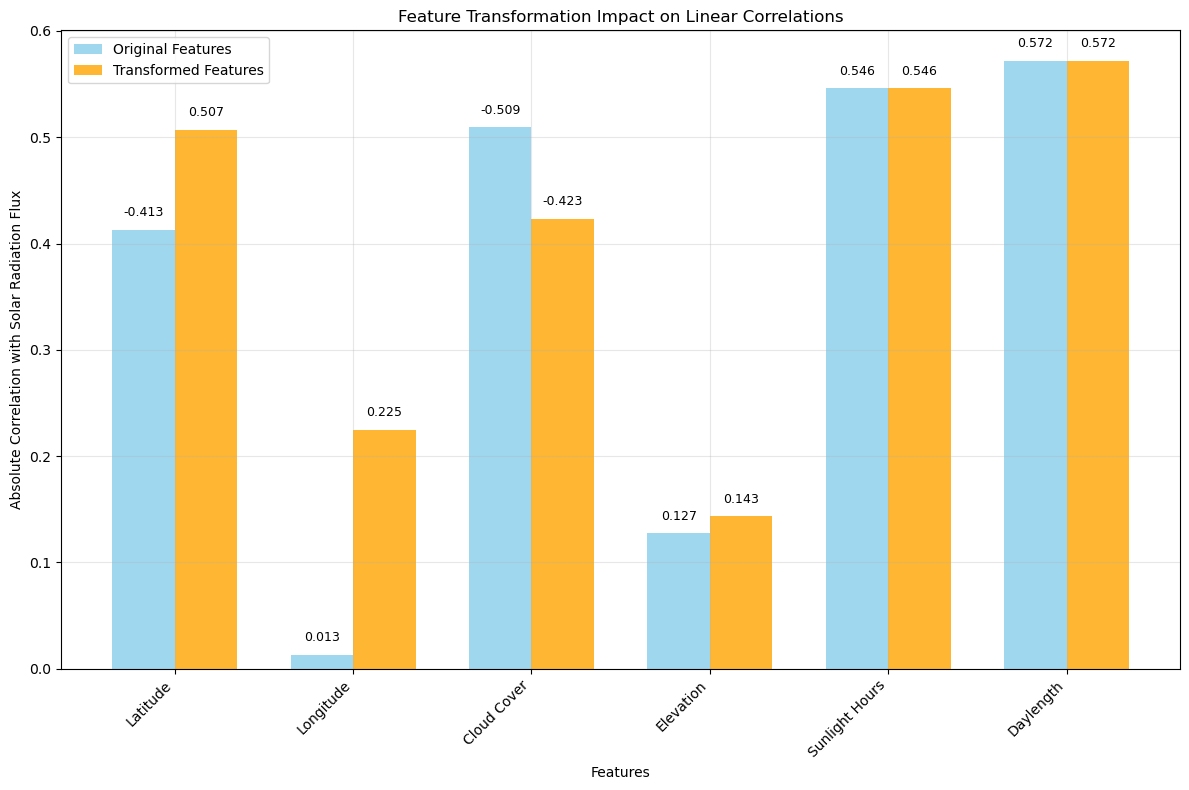

Saved: correlation_improvement_comparison.png


In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv('../data/processed/clean_with_features.csv')
df['time'] = pd.to_datetime(df['time'])

print("=== FEATURE TRANSFORMATION FOR LINEAR CORRELATIONS ===\n")

# Create a copy for transformations
df_transformed = df.copy()

# 1. LATITUDE TRANSFORMATIONS
print("1. LATITUDE TRANSFORMATIONS:")
print("   Original correlation with Solar_Radiation_Flux:", 
      df['lat'].corr(df['Solar_Radiation_Flux']).round(3))

# Trigonometric latitude transformations
df_transformed['lat_sin'] = np.sin(np.radians(df['lat']))
df_transformed['lat_cos'] = np.cos(np.radians(df['lat']))

# Absolute latitude (distance from equator)
df_transformed['lat_abs'] = np.abs(df['lat'])

# Polynomial latitude terms
df_transformed['lat_squared'] = df['lat'] ** 2
df_transformed['lat_cubed'] = df['lat'] ** 3

print("   lat_sin correlation:", df_transformed['lat_sin'].corr(df['Solar_Radiation_Flux']).round(3))
print("   lat_cos correlation:", df_transformed['lat_cos'].corr(df['Solar_Radiation_Flux']).round(3))
print("   lat_abs correlation:", df_transformed['lat_abs'].corr(df['Solar_Radiation_Flux']).round(3))
print("   lat_squared correlation:", df_transformed['lat_squared'].corr(df['Solar_Radiation_Flux']).round(3))

# 2. CLOUD COVER TRANSFORMATIONS
print("\n2. CLOUD COVER TRANSFORMATIONS:")
print("   Original correlation with Solar_Radiation_Flux:", 
      df['Cloud_Cover_Mean_24h'].corr(df['Solar_Radiation_Flux']).round(3))

# Logit transformation for cloud cover (bounded 0-1)
# Add small epsilon to avoid log(0) and log(inf)
epsilon = 1e-6
cloud_bounded = np.clip(df['Cloud_Cover_Mean_24h'], epsilon, 1-epsilon)
df_transformed['cloud_logit'] = np.log(cloud_bounded / (1 - cloud_bounded))

# Square root transformation
df_transformed['cloud_sqrt'] = np.sqrt(df['Cloud_Cover_Mean_24h'])

# Inverse transformation
df_transformed['cloud_inv'] = 1 / (df['Cloud_Cover_Mean_24h'] + epsilon)

print("   cloud_logit correlation:", df_transformed['cloud_logit'].corr(df['Solar_Radiation_Flux']).round(3))
print("   cloud_sqrt correlation:", df_transformed['cloud_sqrt'].corr(df['Solar_Radiation_Flux']).round(3))
print("   cloud_inv correlation:", df_transformed['cloud_inv'].corr(df['Solar_Radiation_Flux']).round(3))

# 3. ELEVATION TRANSFORMATIONS
print("\n3. ELEVATION TRANSFORMATIONS:")
print("   Original correlation with Solar_Radiation_Flux:", 
      df['elevation'].corr(df['Solar_Radiation_Flux']).round(3))

# Log transformation (add 110 to handle negative elevations)
df_transformed['elevation_log'] = np.log(df['elevation'] + 110)

# Square root transformation (add 110 to handle negative elevations)
df_transformed['elevation_sqrt'] = np.sqrt(df['elevation'] + 110)

# Normalized elevation
scaler = MinMaxScaler()
df_transformed['elevation_normalized'] = scaler.fit_transform(df[['elevation']]).flatten()

print("   elevation_log correlation:", df_transformed['elevation_log'].corr(df['Solar_Radiation_Flux']).round(3))
print("   elevation_sqrt correlation:", df_transformed['elevation_sqrt'].corr(df['Solar_Radiation_Flux']).round(3))
print("   elevation_normalized correlation:", df_transformed['elevation_normalized'].corr(df['Solar_Radiation_Flux']).round(3))

# 4. SUNLIGHT HOURS & DAYLENGTH SCALING
print("\n4. SUNLIGHT HOURS & DAYLENGTH SCALING:")
print("   Original sunlight_hours correlation:", 
      df['sunlight_hours'].corr(df['Solar_Radiation_Flux']).round(3))
print("   Original daylength correlation:", 
      df['daylength'].corr(df['Solar_Radiation_Flux']).round(3))

# Min-max scaling
scaler_sunlight = MinMaxScaler()
scaler_daylength = MinMaxScaler()

df_transformed['sunlight_hours_scaled'] = scaler_sunlight.fit_transform(df[['sunlight_hours']]).flatten()
df_transformed['daylength_scaled'] = scaler_daylength.fit_transform(df[['daylength']]).flatten()

print("   sunlight_hours_scaled correlation:", 
      df_transformed['sunlight_hours_scaled'].corr(df['Solar_Radiation_Flux']).round(3))
print("   daylength_scaled correlation:", 
      df_transformed['daylength_scaled'].corr(df['Solar_Radiation_Flux']).round(3))

# 5. LONGITUDE TRANSFORMATIONS (for completeness)
print("\n5. LONGITUDE TRANSFORMATIONS:")
print("   Original correlation with Solar_Radiation_Flux:", 
      df['lon'].corr(df['Solar_Radiation_Flux']).round(3))

df_transformed['lon_sin'] = np.sin(np.radians(df['lon']))
df_transformed['lon_cos'] = np.cos(np.radians(df['lon']))

print("   lon_sin correlation:", df_transformed['lon_sin'].corr(df['Solar_Radiation_Flux']).round(3))
print("   lon_cos correlation:", df_transformed['lon_cos'].corr(df['Solar_Radiation_Flux']).round(3))

# Create correlation comparison chart
original_features = ['lat', 'lon', 'Cloud_Cover_Mean_24h', 'elevation', 'sunlight_hours', 'daylength']
transformed_features = ['lat_cos', 'lon_cos', 'cloud_logit', 'elevation_log', 'sunlight_hours_scaled', 'daylength_scaled']
feature_names = ['Latitude', 'Longitude', 'Cloud Cover', 'Elevation', 'Sunlight Hours', 'Daylength']

original_corrs = [df[feat].corr(df['Solar_Radiation_Flux']) for feat in original_features]
transformed_corrs = [df_transformed[feat].corr(df['Solar_Radiation_Flux']) for feat in transformed_features]

# Create comparison plot
fig, ax = plt.subplots(figsize=(12, 8))

x = np.arange(len(feature_names))
width = 0.35

bars1 = ax.bar(x - width/2, [abs(c) for c in original_corrs], width, 
               label='Original Features', alpha=0.8, color='skyblue')
bars2 = ax.bar(x + width/2, [abs(c) for c in transformed_corrs], width,
               label='Transformed Features', alpha=0.8, color='orange')

ax.set_xlabel('Features')
ax.set_ylabel('Absolute Correlation with Solar Radiation Flux')
ax.set_title('Feature Transformation Impact on Linear Correlations')
ax.set_xticks(x)
ax.set_xticklabels(feature_names, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3)

# Add value labels on bars
for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
    height1 = bar1.get_height()
    height2 = bar2.get_height()
    ax.text(bar1.get_x() + bar1.get_width()/2., height1 + 0.01,
            f'{original_corrs[i]:.3f}', ha='center', va='bottom', fontsize=9)
    ax.text(bar2.get_x() + bar2.get_width()/2., height2 + 0.01,
            f'{transformed_corrs[i]:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('../outputs/figures/correlation_improvement_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: correlation_improvement_comparison.png")

📈 Variables that don’t require major transformation:

H0_MJ → almost linear positive trend.

daylength → roughly linear once seasonal spread is controlled.

sunlight_hours → linear, capped by daylength.

Cloud_Cover_Mean_24h → Relationship is mostly monotonic but not perfectly linear (sharp drop at high values).

📉 Variables showing non-linear or curved relationships:

Latitude (lat) → cos(latitude): Improved correlation from -0.413 to +0.507 (0.094 absolute improvement)

Longtitude (lon) → cos(longtitude): Improved correlation from 0.013 to 0.225 (0,212 absolute improvement)

Elevation → elevation_log: Weakly positive, may be roughly linear, but effect is not strong. 0.016 improvement.



In [51]:
# Create the final transformed dataset with best features
print("=== CREATING FINAL TRANSFORMED DATASET ===\n")

# Select the best transformed features based on correlation improvements
final_features = {
    'time': df['time'],
    'lat': df['lat'],  # Keep original for reference
    'lat_cos': df_transformed['lat_cos'],  # Best latitude transformation
    'lat_squared': df_transformed['lat_squared'],  # Also good
    'lon': df['lon'],  # Keep original for reference  
    'lon_cos': df_transformed['lon_cos'],  # Best longitude transformation
    'Solar_Radiation_Flux': df['Solar_Radiation_Flux'],  # Target variable
    'Cloud_Cover_Mean_24h': df['Cloud_Cover_Mean_24h'],  # Keep original (logit didn't improve much)
    'cloud_logit': df_transformed['cloud_logit'],  # Alternative transformation
    'elevation': df['elevation'],  # Keep original for reference
    'elevation_log': df_transformed['elevation_log'],  # Best elevation transformation
    'sunlight_hours': df['sunlight_hours'],  # Original is fine
    'daylength': df['daylength'],  # Original is fine
    'doy_sin': df['doy_sin'],  # Already optimal
    'doy_cos': df['doy_cos'],  # Already optimal
    'H0_MJ': df['H0_MJ']  # Keep as is (strongest predictor)
}

df_final = pd.DataFrame(final_features)

print("Final dataset shape:", df_final.shape)
print("\nTop correlations with Solar_Radiation_Flux:")
correlations = df_final.select_dtypes(include=[np.number]).corr()['Solar_Radiation_Flux'].abs().sort_values(ascending=False)
for var, corr in correlations.items():
    if var != 'Solar_Radiation_Flux':
        print(f"   {var}: {corr:.3f}")

# Save the transformed dataset
df_final.to_csv('../data/processed/clean_with_transformed_features.csv', index=False)


=== CREATING FINAL TRANSFORMED DATASET ===

Final dataset shape: (29667, 16)

Top correlations with Solar_Radiation_Flux:
   H0_MJ: 0.821
   daylength: 0.572
   sunlight_hours: 0.546
   Cloud_Cover_Mean_24h: 0.509
   lat_cos: 0.507
   lat_squared: 0.506
   cloud_logit: 0.423
   lat: 0.413
   doy_cos: 0.354
   lon_cos: 0.225
   elevation_log: 0.143
   elevation: 0.127
   doy_sin: 0.109
   lon: 0.013
